**Calculating Entropy**

In [ ]:
import numpy as np
import pandas as pd

# Dataset
data = {
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast', 'Sunny', 'Sunny', 'Rain', 'Sunny', 'Overcast', 'Overcast', 'Rain'],
    'Temperature': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Strong'],
    'Class': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
}
df = pd.DataFrame(data)

# Function to calculate entropy
def entropy(labels):
    values, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    return -np.sum(probabilities * np.log2(probabilities))

# Function to calculate information gain
def information_gain(df, feature, target='Class'):
    total_entropy = entropy(df[target])
    values, counts = np.unique(df[feature], return_counts=True)

    weighted_entropy = sum((counts[i] / np.sum(counts)) * entropy(df[df[feature] == values[i]][target]) for i in range(len(values)))
    return total_entropy - weighted_entropy

# Calculating information gain for each feature
features = ['Outlook', 'Temperature', 'Humidity', 'Wind']
info_gains = {feature: information_gain(df, feature) for feature in features}
sorted_info_gains = sorted(info_gains.items(), key=lambda x: x[1], reverse=True)

print("Information Gain for each feature:")
for feature, gain in sorted_info_gains:
    print(f"{feature}: {gain:.4f}")


Information Gain for each feature:
Outlook: 0.2467
Humidity: 0.1518
Wind: 0.0481
Temperature: 0.0292


**Building Decision Tree from Information Gain**

In [ ]:
from collections import Counter

# Function to create a decision tree
class Node:
    def __init__(self, feature=None, value=None, results=None, children=None):
        self.feature = feature
        self.value = value
        self.results = results  # Class distribution at this node
        self.children = children  # Sub-nodes

def build_tree(df, features, target='Class'):
    # If all instances have the same class, return a leaf node
    if len(np.unique(df[target])) == 1:
        return Node(results=dict(Counter(df[target])))

    # If no features left to split, return a leaf node
    if len(features) == 0:
        return Node(results=dict(Counter(df[target])))

    # Choose the best feature based on information gain
    info_gains = {feature: information_gain(df, feature) for feature in features}
    best_feature = max(info_gains, key=info_gains.get)

    # Create root node for the best feature
    tree = Node(feature=best_feature)
    tree.children = {}

    # Split dataset by best feature and create sub-nodes
    for value in np.unique(df[best_feature]):
        sub_data = df[df[best_feature] == value].drop(columns=[best_feature])
        tree.children[value] = build_tree(sub_data, [f for f in features if f != best_feature], target)

    return tree

# Build and print the decision tree
decision_tree = build_tree(df, features)

# Recursive function to print the tree
def print_tree(node, indent=""):
    if node.results:
        print(indent + "Class distribution:", node.results)
    else:
        print(indent + f"{node.feature}")
        for value, child in node.children.items():
            print(indent + f"--> {value}:")
            print_tree(child, indent + "    ")

print("Decision Tree Structure:")
print_tree(decision_tree)


Decision Tree Structure:
Outlook
--> Overcast:
    Class distribution: {'Yes': 4}
--> Rain:
    Wind
    --> Strong:
        Class distribution: {'No': 2}
    --> Weak:
        Class distribution: {'Yes': 3}
--> Sunny:
    Humidity
    --> High:
        Class distribution: {'No': 3}
    --> Normal:
        Class distribution: {'Yes': 2}


**Iris Dataset - Efficient Neural Network Building and Feature Contribution Analysis**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('iris.csv')

# Separate features and target
X = df.drop(columns=['species'])
y = LabelEncoder().fit_transform(df['species'])  # Encode species as integers

# Split the dataset into training and testing sets (80%:20% split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Building & Training Neural Network**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


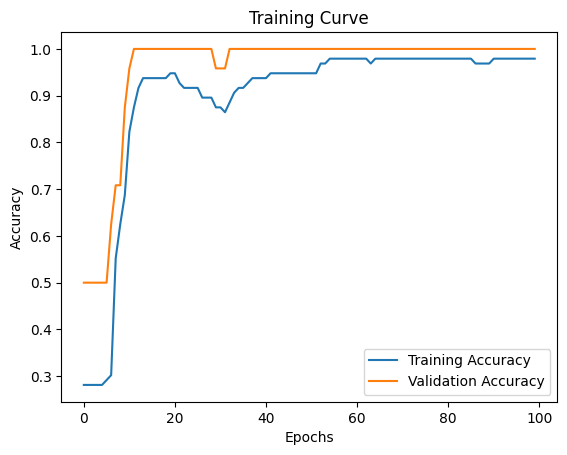

In [ ]:
# Define the neural network model
def build_model(input_shape):
    model = Sequential([
        Dense(10, activation='relu', input_shape=(input_shape,)),
        Dense(10, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and train the model
model = build_model(X_train.shape[1])
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0)

# Plot the training curve
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training Curve")
plt.show()


**Evaluate the Model**

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9667


**Feature Selection using Backward Search**

In [ ]:
def backward_search(X, y):
    features = list(X.columns)
    results = []

    for i in range(len(features)):
        # Drop one feature at a time
        X_temp = X.drop(columns=[features[i]])
        X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_temp, y, test_size=0.2, random_state=42)

        # Build and evaluate the model
        model = build_model(X_train_temp.shape[1])
        model.fit(X_train_temp, y_train_temp, epochs=100, validation_split=0.2, verbose=0)
        test_loss, test_accuracy = model.evaluate(X_test_temp, y_test_temp, verbose=0)

        # Store the results
        results.append((features[i], test_accuracy))
        print(f"Removed Feature: {features[i]}, Test Accuracy: {test_accuracy:.4f}")

    return results

# Perform backward search
backward_search_results = backward_search(X, y)

# Sort and display the feature removal impact on accuracy
sorted_results = sorted(backward_search_results, key=lambda x: x[1], reverse=True)
print("Feature Contribution Ranking (higher accuracy after removal means less contribution):")
for feature, accuracy in sorted_results:
    print(f"Feature Removed: {feature}, Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Removed Feature: sepal_length, Test Accuracy: 0.9667


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Removed Feature: sepal_width, Test Accuracy: 1.0000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Removed Feature: petal_length, Test Accuracy: 0.9000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Removed Feature: petal_width, Test Accuracy: 0.8667
Feature Contribution Ranking (higher accuracy after removal means less contribution):
Feature Removed: sepal_width, Accuracy: 1.0000
Feature Removed: sepal_length, Accuracy: 0.9667
Feature Removed: petal_length, Accuracy: 0.9000
Feature Removed: petal_width, Accuracy: 0.8667


**Training loss with Epochs with Backward Search**


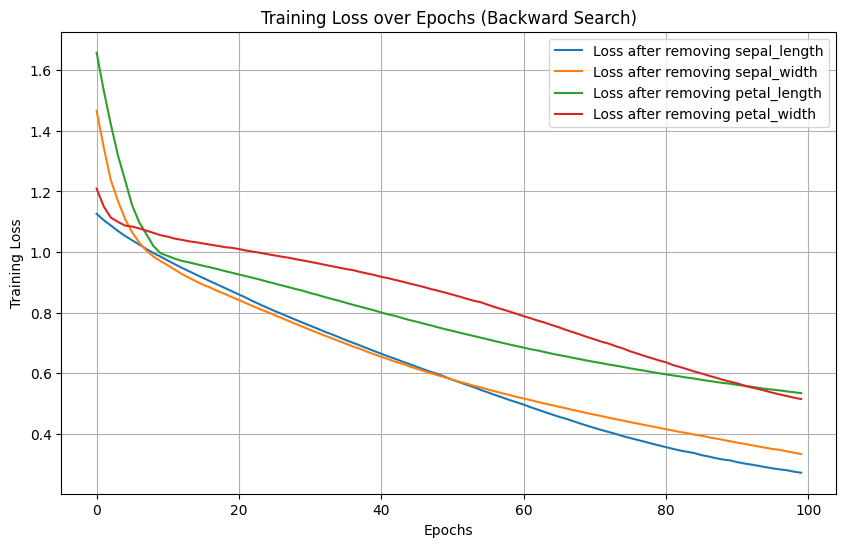

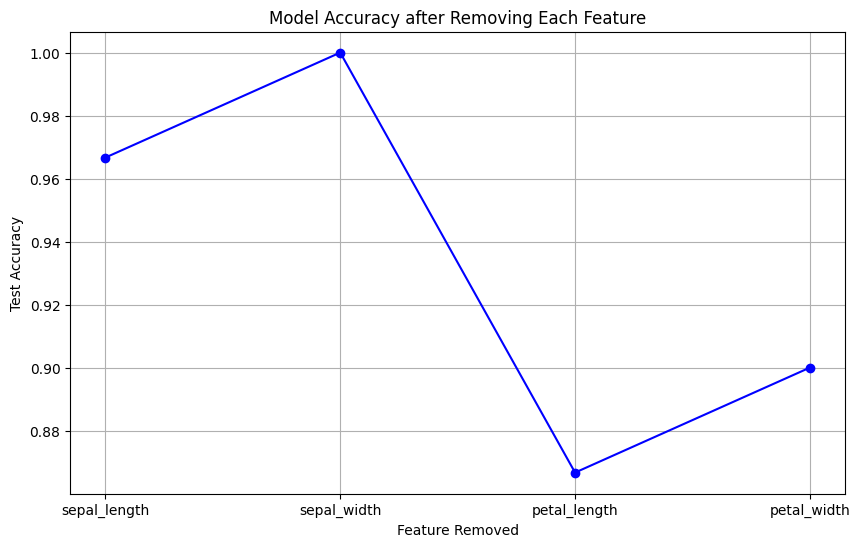

Backward Search Results: [('sepal_length', 0.9666666388511658), ('sepal_width', 1.0), ('petal_length', 0.8666666746139526), ('petal_width', 0.8999999761581421)]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('iris.csv')

# Separate features and target
X = df.drop(columns=['species'])
y = LabelEncoder().fit_transform(df['species'])  # Encode species as integers

# Define the neural network model
def build_model(input_shape):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(10, activation='relu'),
        Dense(10, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform backward search for feature selection and track accuracy and training loss
def backward_search_with_plots(X, y):
    features = list(X.columns)
    feature_accuracy = []

    plt.figure(figsize=(10, 6))

    for i in range(len(features)):
        # Drop one feature at a time
        X_temp = X.drop(columns=[features[i]])
        X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_temp, y, test_size=0.2, random_state=42)

        # Build and train the model
        model = build_model(X_train_temp.shape[1])
        history = model.fit(X_train_temp, y_train_temp, epochs=100, verbose=0)

        # Evaluate the model on the test set
        test_loss, test_accuracy = model.evaluate(X_test_temp, y_test_temp, verbose=0)
        feature_accuracy.append((features[i], test_accuracy))

        # Plot training loss over epochs for each iteration
        plt.plot(history.history['loss'], label=f"Loss after removing {features[i]}")

    # Display the training loss plot
    plt.title('Training Loss over Epochs (Backward Search)')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot feature accuracy after each removal
    feature_names = [x[0] for x in feature_accuracy]
    accuracies = [x[1] for x in feature_accuracy]

    plt.figure(figsize=(10, 6))
    plt.plot(feature_names, accuracies, marker='o', linestyle='-', color='b')
    plt.title('Model Accuracy after Removing Each Feature')
    plt.xlabel('Feature Removed')
    plt.ylabel('Test Accuracy')
    plt.grid()
    plt.show()

    return feature_accuracy

# Perform backward search with plots
backward_search_results = backward_search_with_plots(X, y)
print("Backward Search Results:", backward_search_results)
